In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from scipy.optimize import curve_fit
from scipy import stats
import os
import numpy as np
import glob

In [79]:
def KL(P,Q, epsilon):
    
    # """ Epsilon is used here to avoid conditional code for
    # checking that neither P nor Q is equal to 0. """
    #      epsilon = 1e-20
    
    P = P+epsilon
    Q = Q+epsilon
    divergence = np.sum(P*np.log(P/Q))
    return divergence

In [3]:
def plotCummulative(subset):
    import matplotlib.cm as cm
    colors = cm.jet(np.linspace(0, 1, len(bin_id)))

    flowershape = ['c1', 'c2', 'c3', 'c10']
#     subset = [subset_c1, subset_c2, subset_c3, subset_c10]

    fig, ax = plt.subplots(1,len(subset), figsize=(20,6))
    for shape, i in zip(subset,range(len(ax))):
        data = shape
        cc = 0
        for bin in bin_id:
            value, base = np.histogram(data.loc[data.myBin == bin, 'DiscoveryTime'].values/100,
                      bins, density = True)
            cummulative = np.cumsum(value)
            ax[i].plot(base[:-1], cummulative, label = bin, color = colors[cc])
            ax[i].set_title(flowershape[i])
            cc+=1

    plt.legend(bbox_to_anchor=(1.0, 1.0))
    return ax

In [237]:
outpath_fig = './dataFolders/Output/Figures/Distributions/'
path = './dataFolders/Output/Step6_FloralTypeConsolidatedData_AndFitParameters/'

In [9]:
# Fix the bin number and edges based on ALL the data pooled together
shapes = ['c-1', 'c-2', 'c-3', 'c-10']
AllShapes = pd.DataFrame([])

for floralShape in shapes:
    file = glob.glob(path + floralShape + '_Alltrials.csv')[0]
    data = pd.read_csv(file)
    AllShapes = AllShapes.append(data)

In [19]:
# check for duplicates

AllShapes[AllShapes.duplicated()]

Empty DataFrame
Columns: [Unnamed: 0, MothIn, MothOut, ProboscisDetect, DiscoveryTime, trialNum, name, binnedBy3s, flower, cumBinnedBy3s]
Index: []

### bin the data in sets of N

In [10]:
AllShapes.loc[:,'trialNum'] = AllShapes.loc[:,'trialNum']+1

In [267]:
# bin data 

binsize = 4
bin = np.arange(0,40, binsize)
bin = np.append(bin,max(AllShapes['trialNum'])+1)
label = [str(i) for i in bin][1:]

AllShapes['binnedBy3s']=pd.cut(AllShapes['trialNum'], bin, labels = label)
AllShapes.head()

Unnamed: 0  MothIn  MothOut  ProboscisDetect  DiscoveryTime  trialNum  \
0           0   31485    33858          31825.0          340.0         1   
1           1   35183    36433          35616.0          433.0         2   
2           2   37230    37741          37351.0          121.0         3   
3           3   37830    38106              NaN            NaN         4   
4           4   38344    38965          38438.0           94.0         5   

      name binnedBy3s flower cumBinnedBy3s  
0  c-1_m10          4    c-1             3  
1  c-1_m10          4    c-1             3  
2  c-1_m10          4    c-1             3  
3  c-1_m10          4    c-1             6  
4  c-1_m10          8    c-1             6

In [268]:
# add a label for flower type
test = AllShapes['name'].str.split('_', n = 1, expand = True)
AllShapes.loc[:,'flower'] = test[0]

### plot the binned data by not in sets of 3s but as 0 to that bin edge

In [269]:
binsize = 4
binning = np.arange(0,40, binsize)
binning = np.append(binning,max(AllShapes['trialNum'])+1)
binning = binning[::-1]

for bin in binning:
    AllShapes.loc[AllShapes.trialNum < bin + 1, 'cumBinnedBy3s'] = str(bin)

AllShapes.tail()

Unnamed: 0  MothIn  MothOut  ProboscisDetect  DiscoveryTime  trialNum  \
740         740   97476    98118              NaN            NaN        15   
741         741   98944    99206              NaN            NaN        16   
742         742  100730   103133              NaN            NaN        17   
743         743  104164   104783              NaN            NaN        18   
744         744  105430   105898              NaN            NaN        19   

        name binnedBy3s flower cumBinnedBy3s  
740  c-10_m9         16   c-10            16  
741  c-10_m9         16   c-10            16  
742  c-10_m9         20   c-10            20  
743  c-10_m9         20   c-10            20  
744  c-10_m9         20   c-10            20

### Remove nan to calculate the zscore

In [270]:
AllShapes_notnull = AllShapes[AllShapes.DiscoveryTime.notnull()].copy()
z = np.abs(stats.zscore(AllShapes_notnull.DiscoveryTime.values))
outlier_ID = z > 5 
plt.plot(z, 'o') 

AllShapes_notnull.loc[:,'zscore'] = pd.Series(data = z, index = AllShapes_notnull.index)
AllShapes_notnull.loc[:,'outlier_ID'] = pd.Series(data = outlier_ID, index = AllShapes_notnull.index)

In [16]:
AllShapes_notnull.to_csv(path+'notnull_All_Data.csv')

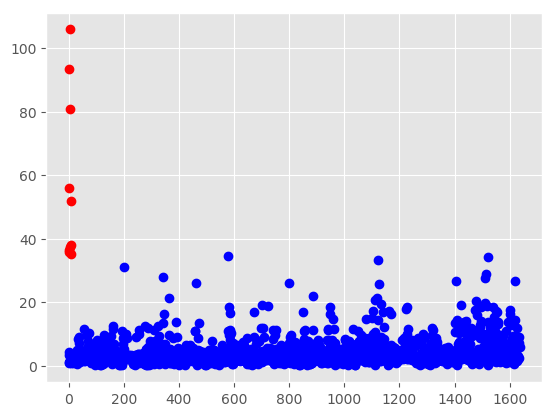

In [271]:
plt.plot(AllShapes_notnull.loc[AllShapes_notnull.outlier_ID == True, 'DiscoveryTime'].values/100,
         'o', color = 'red')
plt.plot(AllShapes_notnull.loc[AllShapes_notnull.outlier_ID == False, 'DiscoveryTime'].values/100,
         'o', color = 'blue')
plt.show()

ValuesConsidered = AllShapes_notnull.loc[:, 'DiscoveryTime'].values/100
plt.plot(ValuesConsidered, 'o', color = 'red')
plt.show()

### Try to merge all both df

In [34]:
# AllShapes.loc[:, 'zscore'] = np.nan
# AllShapes.loc[:,'outlier_ID'] = np.nan

In [35]:
# print(AllShapes.shape, AllShapes_notnull.shape)

(2781, 9) (1647, 9)


In [156]:
# uber_df = pd.merge(AllShapes,
#                   AllShapes_notnull)
# print(uber_df.shape)
# uber_df.head()

# plot histogram for different bins

In [272]:
notoutliers = AllShapes_notnull.loc[AllShapes_notnull['outlier_ID'] == False].copy()

In [276]:
# plot as box plots 

import seaborn as sns

fig, ax = plt.subplots(figsize = (20,6))

# Grouped boxplot
sns.boxplot(ax = ax, x="flower", y="DiscoveryTime", hue="binnedBy3s", data=notoutliers, palette="Set1")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig(outpath_fig + 'Histogram_eachBin_acrossFlowers.png')
# sns.plt.show()

In [273]:
hist, bins = np.histogram(notoutliers['DiscoveryTime'].values/100, bins = 25)

fig, ax = plt.subplots(2,4, figsize = (20,6))
ax = ax.ravel()

ax[0].hist(notoutliers['DiscoveryTime'].values/100,
           bins, density = True, orientation = 'horizontal', label = 'AllData')
ax[0].legend()
ax[4].hist(notoutliers.DiscoveryTime[notoutliers.name.str.contains('c-1_')].values/100, 
           bins, density = True, orientation = 'horizontal' , label = 'c1')
ax[4].legend()
ax[5].hist(notoutliers.DiscoveryTime[notoutliers.name.str.contains('c-2_')].values/100,
           bins, density = True, orientation = 'horizontal', label = 'c2')
ax[5].legend()
ax[6].hist(notoutliers.DiscoveryTime[notoutliers.name.str.contains('c-3_')].values/100,
           bins, density = True, orientation = 'horizontal', label = 'c3')
ax[6].legend()
ax[7].hist(notoutliers.DiscoveryTime[notoutliers.name.str.contains('c-10_')].values/100,
           bins, density = True, orientation = 'horizontal', label = 'c10')
ax[7].legend()

plt.savefig(outpath_fig + 'AllData_histogram.png')

In [305]:
# across flowers compare across bins

subset_c1 = notoutliers.loc[notoutliers.flower == 'c-1', ['DiscoveryTime', 'binnedBy3s']].copy()
subset_c2 = notoutliers.loc[notoutliers.flower == 'c-2', ['DiscoveryTime', 'binnedBy3s']].copy()
subset_c3 = notoutliers.loc[notoutliers.flower == 'c-3', ['DiscoveryTime', 'binnedBy3s']].copy()
subset_c10 = notoutliers.loc[notoutliers.flower == 'c-10', ['DiscoveryTime', 'binnedBy3s']].copy()

subset_c10.tail()

DiscoveryTime binnedBy3s
729          214.0          4
732          713.0          8
733          908.0          8
735          250.0         12
737          580.0         12

### plot the cummulative curves

In [306]:
# from cycler import cycler
# import matplotlib as mpl
import matplotlib.cm as cm

fig, ax = plt.subplots(1,4, figsize = (20,6))

bin_id = notoutliers.binnedBy3s.unique()

colors = cm.jet(np.linspace(0, 1, len(bin_id)))
# Change default color cycle for each shape
# mpl.rcParams['axes.prop_cycle']= cycler(color = 'brg')
i = 0
for bin in bin_id:
    ax[0].hist(subset_c1.loc[subset_c1.binnedBy3s == bin, 'DiscoveryTime'].values/100,
              bins , density = True, histtype = 'step', 
               cumulative = True, label = bin, color = colors[i])
    ax[0].legend()
    i+=1

#     bins, density=True, histtype='step', color = 'darkorange',
#         cumulative=True, label='highLight', orientation = 'horizontal')

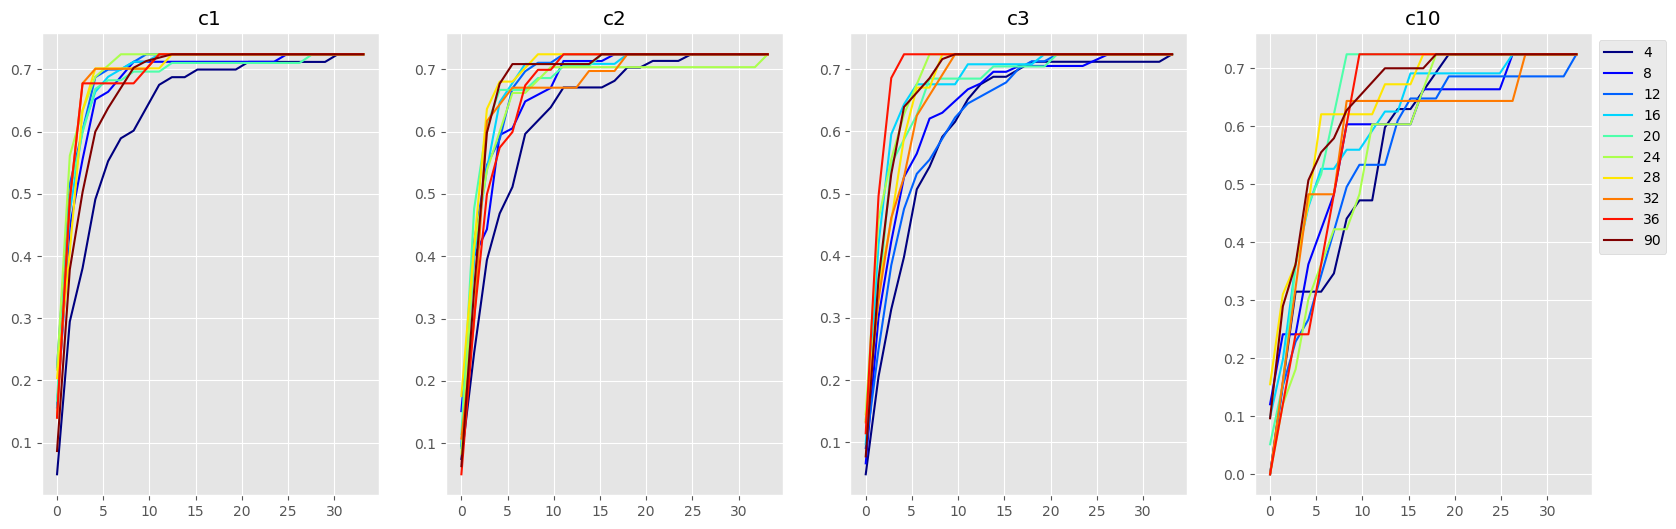

In [302]:
# across flowers compare across cummulative bins - use function :P !
style.use('ggplot')
subset_c1 = notoutliers.loc[notoutliers.flower == 'c-1', ['DiscoveryTime', 'binnedBy3s']].copy()
subset_c1.rename(columns = {'binnedBy3s': 'myBin'}, inplace = True)
subset_c2 = notoutliers.loc[notoutliers.flower == 'c-2', ['DiscoveryTime', 'binnedBy3s']].copy()
subset_c2.rename(index = str, columns = {'binnedBy3s': 'myBin'}, inplace = True)
subset_c3 = notoutliers.loc[notoutliers.flower == 'c-3', ['DiscoveryTime', 'binnedBy3s']].copy()
subset_c3.rename(index = str, columns = {'binnedBy3s': 'myBin'}, inplace = True)
subset_c10 = notoutliers.loc[notoutliers.flower == 'c-10', ['DiscoveryTime', 'binnedBy3s']].copy()
subset_c10.rename(index = str, columns = {'binnedBy3s': 'myBin'}, inplace = True)
subset = [subset_c1, subset_c2, subset_c3, subset_c10]
plotCummulative(subset)
# subset_c1.head()

plt.savefig(outpath_fig + 'cummulative_eachBin_acrossFlowers.png')

## Do stats on these distributions

In [278]:
a = ['c1', 'c2', 'c3', 'c10']
b = list(bin_id)

tuples = [(p1, p2) for p1 in a for p2 in b]
# tuples
index = pd.MultiIndex.from_tuples(tuples, names=['flowerType', 'VisitNumber'])
distributions_binned = pd.DataFrame(data = None, index=index, columns = list(bins[1:]))
distributions_binned.tail()

1.3908  2.7716  4.1524  5.5332  6.9140  8.2948   \
flowerType VisitNumber                                                   
c10        24              NaN     NaN     NaN     NaN     NaN     NaN   
           28              NaN     NaN     NaN     NaN     NaN     NaN   
           32              NaN     NaN     NaN     NaN     NaN     NaN   
           36              NaN     NaN     NaN     NaN     NaN     NaN   
           90              NaN     NaN     NaN     NaN     NaN     NaN   

                       9.6756  11.0564 12.4372 13.8180   ...   22.1028  \
flowerType VisitNumber                                   ...             
c10        24              NaN     NaN     NaN     NaN   ...       NaN   
           28              NaN     NaN     NaN     NaN   ...       NaN   
           32              NaN     NaN     NaN     NaN   ...       NaN   
           36              NaN     NaN     NaN     NaN   ...       NaN   
           90              NaN     NaN     NaN     NaN   ...       NaN   

                       23.4836 24.8644 26.2452 27.6260 29.0068 30.3876  \
flowerType VisitNumber                                                   
c10        24              NaN     NaN     NaN     NaN     NaN     NaN   
           28              NaN     NaN     NaN     NaN     NaN     NaN   
           32              NaN     NaN     NaN     NaN     NaN     NaN   
           36              NaN     NaN     NaN     NaN     NaN     NaN   
           90              NaN     NaN     NaN     NaN     NaN     NaN   

                       31.7684 33.1492 34.5300  
flowerType VisitNumber                          
c10        24              NaN     NaN     NaN  
           28              NaN     NaN     NaN  
           32              NaN     NaN     NaN  
           36              NaN     NaN     NaN  
           90              NaN     NaN     NaN  

[5 rows x 25 columns]

In [279]:
subset_c1.tail()

DiscoveryTime myBin
695          123.0    32
698          396.0    36
699          200.0    36
700          186.0    36
701          398.0    90

In [280]:
bin_id

[4, 8, 12, 16, 20, 24, 28, 32, 36, 90]
Categories (10, object): [4 < 8 < 12 < 16 ... 28 < 32 < 36 < 90]

In [281]:
# fill in the distributions binned as 0 - bin edge

flowershape = ['c1', 'c2', 'c3', 'c10']

cc= 0
for shape in subset: 
    data = shape
    for binEdge in list(bin_id):
        selected_data = data.loc[(data.myBin == binEdge), 'DiscoveryTime'].values/100
#         selected_data
#         print(len(selected_data), binEdge)
        hist, _ = np.histogram(selected_data, bins = bins,
                           density = True)
        distributions_binned.loc[(flowershape[cc], binEdge), :] = hist
    cc+=1 

distributions_binned = distributions_binned.astype('float64')
distributions_binned.head()

1.3908    2.7716    4.1524    5.5332    6.9140   \
flowerType VisitNumber                                                     
c1         4            0.049100  0.245498  0.085924  0.110474  0.061374   
           8            0.156914  0.289687  0.108633  0.096562  0.012070   
           12           0.220948  0.294597  0.085924  0.085924  0.012275   
           16           0.156914  0.313828  0.132773  0.060351  0.024141   
           20           0.167127  0.334254  0.097491  0.069636  0.013927   

                         8.2948    9.6756    11.0564   12.4372   13.8180  \
flowerType VisitNumber                                                     
c1         4            0.036825  0.012275  0.036825  0.036825  0.012275   
           8            0.024141  0.024141  0.000000  0.000000  0.000000   
           12           0.000000  0.012275  0.012275  0.000000  0.000000   
           16           0.012070  0.012070  0.000000  0.012070  0.000000   
           20           0.000000  0.013927  0.000000  0.000000  0.013927   

                         ...      22.1028  23.4836  24.8644  26.2452  27.6260  \
flowerType VisitNumber   ...                                                    
c1         4             ...     0.012275      0.0      0.0  0.00000      0.0   
           8             ...     0.000000      0.0      0.0  0.01207      0.0   
           12            ...     0.000000      0.0      0.0  0.00000      0.0   
           16            ...     0.000000      0.0      0.0  0.00000      0.0   
           20            ...     0.000000      0.0      0.0  0.00000      0.0   

                         29.0068  30.3876   31.7684  33.1492  34.5300  
flowerType VisitNumber                                                 
c1         4            0.000000      0.0  0.012275      0.0      0.0  
           8            0.000000      0.0  0.000000      0.0      0.0  
           12           0.000000      0.0  0.000000      0.0      0.0  
           16           0.000000      0.0  0.000000      0.0      0.0  
           20           0.013927      0.0  0.000000      0.0      0.0  

[5 rows x 25 columns]

In [282]:
# make a dataframe to hold the stats

a = ['c1', 'c2', 'c3', 'c10']
b = list(bin_id)

tuples = [(p1, p2) for p1 in b for p2 in a]
# tuples
index = pd.MultiIndex.from_tuples(tuples, names=['VisitNumber', 'flowerType'])
stats_kl_df_binned = pd.DataFrame(data = None, index=index, columns = a)
stats_ks_df_binned = pd.DataFrame(data = None, index=index, columns = a)
stats_kl_df_binned.head()

c1   c2   c3  c10
VisitNumber flowerType                    
4           c1          NaN  NaN  NaN  NaN
            c2          NaN  NaN  NaN  NaN
            c3          NaN  NaN  NaN  NaN
            c10         NaN  NaN  NaN  NaN
8           c1          NaN  NaN  NaN  NaN

In [283]:
# do the stats and fill in the dfs

combinations = [(p1, p2) for p1 in a for p2 in a]

for binEdge in b:
    for p1,p2 in combinations:
        cdf_1 = distributions_binned.loc[(p1, binEdge), :].values
        cdf_2 = distributions_binned.loc[(p2, binEdge), :].values
        _, ks_p = stats.ks_2samp(cdf_1, cdf_2)
        stats_ks_df_binned.loc[(binEdge, p1), p2] = ks_p
        
        kl_dist = KL(P=cdf_1, Q=cdf_2, epsilon=1e-20)
        stats_kl_df_binned.loc[(binEdge, p1), p2] = kl_dist

In [288]:
style.use('default')
stats_kl_df_binned = stats_kl_df_binned.astype('float64')
stats_ks_df_binned = stats_ks_df_binned.astype('float64')
vmin = 0
vmax = max(stats_kl_df_binned.apply(max).values)
# plt.imshow(relevant_kl)

bin_id = notoutliers.binnedBy3s.unique()

row = int(np.ceil(len(bin_id)/4))

fig, ax = plt.subplots(row,4, figsize=(20,15))
ax = ax.ravel()

for binEdge, ii in zip(bin_id,range(len(ax))):
    relevant_kl = stats_kl_df_binned.loc[(binEdge)]
    relevant_ks = stats_ks_df_binned.loc[(binEdge)].values
    im = ax[ii].imshow(relevant_kl)

    # We want to show all ticks...
    ax[ii].set_xticks(np.arange(len(relevant_kl.index)))
    ax[ii].set_yticks(np.arange(len(relevant_kl.columns)))
    # ... and label them with the respective list entries
    ax[ii].set_xticklabels(relevant_kl.index)
    ax[ii].set_yticklabels(relevant_kl.columns)
    
    fig.colorbar(im, ax = ax[ii], shrink = 0.5)
    # Loop over data dimensions and create text annotations.
    for i in range(len(relevant_kl.index)):
        for j in range(len(relevant_kl.columns)):
            text = ax[ii].text(j, i, round(relevant_kl.iloc[i, j],2),
                           ha="center", va="center", color="w")
            if relevant_ks[i,j] <= 0.05:
                ax[ii].scatter(j, i-0.2, s=50, c='lavender', marker='*')

plt.savefig(outpath_fig + 'Stats-eachBin-acrossBin.png')

In [289]:
lowest_pvalue = min(stats_ks_df_binned.apply(min).values)
lowest_pvalue

0.12361290897553281

## plot distributions as "0 - bin edge"!

In [291]:
# across flowers compare across bins

subset_c1 = notoutliers.loc[notoutliers.flower == 'c-1', ['DiscoveryTime', 'trialNum']].copy()
subset_c2 = notoutliers.loc[notoutliers.flower == 'c-2', ['DiscoveryTime', 'trialNum']].copy()
subset_c3 = notoutliers.loc[notoutliers.flower == 'c-3', ['DiscoveryTime', 'trialNum']].copy()
subset_c10 = notoutliers.loc[notoutliers.flower == 'c-10', ['DiscoveryTime', 'trialNum']].copy()

In [293]:
style.use('ggplot')
import matplotlib.cm as cm
colors = cm.jet(np.linspace(0, 1, len(bin_id)))

flowershape = ['c1', 'c2', 'c3', 'c10']
subset = [subset_c1, subset_c2, subset_c3, subset_c10]

bin_id = notoutliers.binnedBy3s.unique()

fig, ax = plt.subplots(1,len(subset), figsize=(20,6))
for shape, i in zip(subset,range(len(ax))):
    data = shape
    cc = 0
    for bin in bin_id:
        value, base = np.histogram(data.loc[(data.trialNum < int(bin) + 1), 'DiscoveryTime'].values/100,
                  bins, density = True)
        cummulative = np.cumsum(value)
        ax[i].plot(base[:-1], cummulative, label = bin, color = colors[cc])
        ax[i].set_title(flowershape[i])
        cc+=1
#         ax[i].set_xscale('log')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig(outpath_fig + 'Cummulative-0toBinEdge.png')

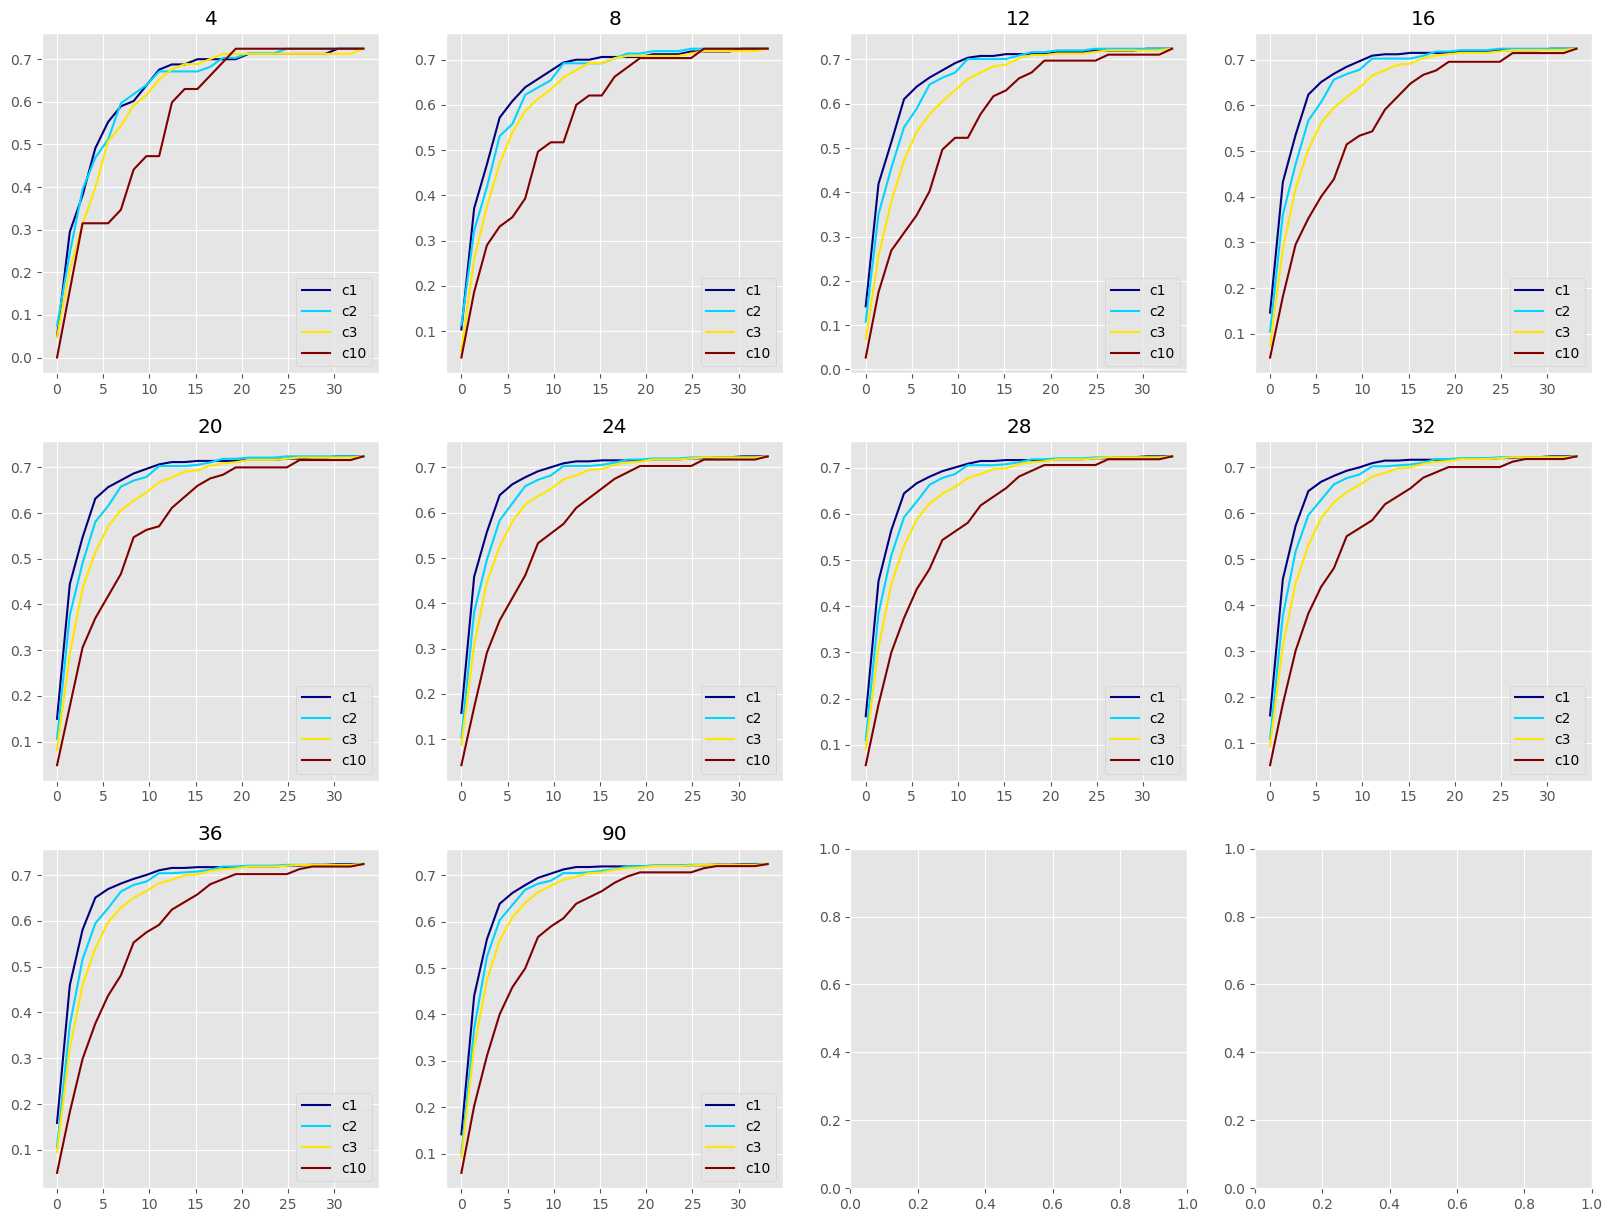

In [294]:
# compare the curves across flower for each bin.

import matplotlib.cm as cm
colors = cm.jet(np.linspace(0, 1, len(subset)))

flowershape = ['c1', 'c2', 'c3', 'c10']
subset = [subset_c1, subset_c2, subset_c3, subset_c10]

bin_id = notoutliers.binnedBy3s.unique()

row = int(np.ceil(len(bin_id)/4))

fig, ax = plt.subplots(row,4, figsize=(20,15))
ax = ax.ravel()
for bin, i in zip(bin_id,range(len(ax))):
    cc = 0
    for shape in subset:
        data = shape
        value, base = np.histogram(data.loc[(data.trialNum < int(bin) + 1), 'DiscoveryTime'].values/100,
                  bins, density = True)
        cummulative = np.cumsum(value)
        ax[i].plot(base[:-1], cummulative, label = flowershape[cc], color = colors[cc])
        ax[i].set_title(bin)
        ax[i].legend()
#         print(i, cc, flowershape[cc])
        cc+=1
#         ax[i].set_xscale('log')
# plt.legend(bbox_to_anchor=(1.0, 1.0))

plt.savefig(outpath_fig + 'Cummulative-0toBinEdge-perBin.png')

In [295]:
# plot histogram, not cummulative one
import matplotlib.cm as cm
colors = cm.Dark2(np.linspace(0, 1, len(subset)))

flowershape = ['c1', 'c2', 'c3', 'c10']
#     subset = [subset_c1, subset_c2, subset_c3, subset_c10]

bin_id = notoutliers.binnedBy3s.unique()

row = int(np.ceil(len(bin_id)/4))

fig, ax = plt.subplots(row,4, figsize=(20,15))
ax = ax.ravel()
for bin, i in zip(bin_id,range(len(ax))):
    cc = 0
    for shape in subset:
        data = shape
        ax[i].hist(data.loc[(data.trialNum < int(bin) + 1), 'DiscoveryTime'].values/100,
              bins , density = True, histtype = 'step',
                   cumulative = False,
                   orientation = 'horizontal',
                   label = flowershape[cc], 
                   color = colors[cc],
                  alpha = 0.7,
                  linewidth = 2)
        ax[i].set_title(bin)
        ax[i].legend()
        cc+=1
        
plt.savefig(outpath_fig + 'Histogram-0toBinEdge-perBin.png')

### Do statistics on the different distributions

In [296]:
a = ['c1', 'c2', 'c3', 'c10']
b = list(bin_id)

tuples = [(p1, p2) for p1 in a for p2 in b]
# tuples
index = pd.MultiIndex.from_tuples(tuples, names=['flowerType', 'MaxVisitNumber'])
distributions = pd.DataFrame(data = None, index=index, columns = list(bins[1:]))
distributions.tail()

1.3908  2.7716  4.1524  5.5332  6.9140  8.2948   \
flowerType MaxVisitNumber                                                   
c10        24                 NaN     NaN     NaN     NaN     NaN     NaN   
           28                 NaN     NaN     NaN     NaN     NaN     NaN   
           32                 NaN     NaN     NaN     NaN     NaN     NaN   
           36                 NaN     NaN     NaN     NaN     NaN     NaN   
           90                 NaN     NaN     NaN     NaN     NaN     NaN   

                          9.6756  11.0564 12.4372 13.8180   ...   22.1028  \
flowerType MaxVisitNumber                                   ...             
c10        24                 NaN     NaN     NaN     NaN   ...       NaN   
           28                 NaN     NaN     NaN     NaN   ...       NaN   
           32                 NaN     NaN     NaN     NaN   ...       NaN   
           36                 NaN     NaN     NaN     NaN   ...       NaN   
           90                 NaN     NaN     NaN     NaN   ...       NaN   

                          23.4836 24.8644 26.2452 27.6260 29.0068 30.3876  \
flowerType MaxVisitNumber                                                   
c10        24                 NaN     NaN     NaN     NaN     NaN     NaN   
           28                 NaN     NaN     NaN     NaN     NaN     NaN   
           32                 NaN     NaN     NaN     NaN     NaN     NaN   
           36                 NaN     NaN     NaN     NaN     NaN     NaN   
           90                 NaN     NaN     NaN     NaN     NaN     NaN   

                          31.7684 33.1492 34.5300  
flowerType MaxVisitNumber                          
c10        24                 NaN     NaN     NaN  
           28                 NaN     NaN     NaN  
           32                 NaN     NaN     NaN  
           36                 NaN     NaN     NaN  
           90                 NaN     NaN     NaN  

[5 rows x 25 columns]

In [297]:
# fill in the distributions binned as 0 - bin edge

flowershape = ['c1', 'c2', 'c3', 'c10']

cc= 0
for shape in subset: 
    data = shape
    for binEdge in list(bin_id):
        selected_data = data.loc[(data.trialNum < int(binEdge) + 1), 'DiscoveryTime'].values/100
#         selected_data
#         print(len(selected_data), binEdge)
        hist, _ = np.histogram(selected_data, bins = bins,
                           density = True)
        distributions.loc[(flowershape[cc], binEdge), :] = hist
    cc+=1 

distributions = distributions.astype('float64')
distributions.head()

1.3908    2.7716    4.1524    5.5332    6.9140   \
flowerType MaxVisitNumber                                                     
c1         4               0.049100  0.245498  0.085924  0.110474  0.061374   
           8               0.103460  0.267778  0.097374  0.103460  0.036515   
           12              0.142402  0.276667  0.093579  0.097647  0.028480   
           16              0.146061  0.286036  0.103460  0.088245  0.027386   
           20              0.149838  0.294682  0.102389  0.084908  0.024973   

                            8.2948    9.6756    11.0564   12.4372   13.8180  \
flowerType MaxVisitNumber                                                     
c1         4               0.036825  0.012275  0.036825  0.036825  0.012275   
           8               0.030429  0.018258  0.018258  0.018258  0.006086   
           12              0.020343  0.016275  0.016275  0.012206  0.004069   
           16              0.018258  0.015215  0.012172  0.012172  0.003043   
           20              0.014984  0.014984  0.009989  0.009989  0.004995   

                            ...      22.1028  23.4836  24.8644   26.2452  \
flowerType MaxVisitNumber   ...                                            
c1         4                ...     0.012275      0.0      0.0  0.000000   
           8                ...     0.006086      0.0      0.0  0.006086   
           12               ...     0.004069      0.0      0.0  0.004069   
           16               ...     0.003043      0.0      0.0  0.003043   
           20               ...     0.002497      0.0      0.0  0.002497   

                           27.6260   29.0068  30.3876   31.7684  33.1492  \
flowerType MaxVisitNumber                                                  
c1         4                   0.0  0.000000      0.0  0.012275      0.0   
           8                   0.0  0.000000      0.0  0.006086      0.0   
           12                  0.0  0.000000      0.0  0.004069      0.0   
           16                  0.0  0.000000      0.0  0.003043      0.0   
           20                  0.0  0.002497      0.0  0.002497      0.0   

                           34.5300  
flowerType MaxVisitNumber           
c1         4                   0.0  
           8                   0.0  
           12                  0.0  
           16                  0.0  
           20                  0.0  

[5 rows x 25 columns]

In [298]:
# make a dataframe to hold the stats

a = ['c1', 'c2', 'c3', 'c10']
b = list(bin_id)

tuples = [(p1, p2) for p1 in b for p2 in a]
# tuples
index = pd.MultiIndex.from_tuples(tuples, names=['MaxVisitNumber', 'flowerType'])
stats_kl_df = pd.DataFrame(data = None, index=index, columns = a)
stats_ks_df = pd.DataFrame(data = None, index=index, columns = a)
stats_kl_df.head()

c1   c2   c3  c10
MaxVisitNumber flowerType                    
4              c1          NaN  NaN  NaN  NaN
               c2          NaN  NaN  NaN  NaN
               c3          NaN  NaN  NaN  NaN
               c10         NaN  NaN  NaN  NaN
8              c1          NaN  NaN  NaN  NaN

In [299]:
# do the stats and fill in the dfs

combinations = [(p1, p2) for p1 in a for p2 in a]

for binEdge in b:
    for p1,p2 in combinations:
        cdf_1 = distributions.loc[(p1, binEdge), :].values
        cdf_2 = distributions.loc[(p2, binEdge), :].values
        _, ks_p = stats.ks_2samp(cdf_1, cdf_2)
        stats_ks_df.loc[(binEdge, p1), p2] = ks_p
        
        kl_dist = KL(P=cdf_1, Q=cdf_2, epsilon=1e-20)
        stats_kl_df.loc[(binEdge, p1), p2] = kl_dist

In [300]:
stats_ks_df.tail()

c1        c2        c3       c10
MaxVisitNumber flowerType                                         
36             c10         0.0258333  0.123613   0.23701         1
90             c1                  1  0.414063  0.059027  0.123613
               c2           0.414063         1  0.989632  0.123613
               c3           0.059027  0.989632         1   0.23701
               c10          0.123613  0.123613   0.23701         1

In [301]:
style.use('default')
stats_kl_df = stats_kl_df.astype('float64')
stats_ks_df = stats_ks_df.astype('float64')
vmin = 0
vmax = max(stats_kl_df.apply(max).values)
# plt.imshow(relevant_kl)

bin_id = notoutliers.binnedBy3s.unique()

row = int(np.ceil(len(bin_id)/4))

fig, ax = plt.subplots(row,4, figsize=(20,15))
ax = ax.ravel()

for binEdge, ii in zip(bin_id,range(len(ax))):
    relevant_kl = stats_kl_df.loc[(binEdge)]
    relevant_ks = stats_ks_df.loc[(binEdge)].values
    im = ax[ii].imshow(relevant_kl)

    # We want to show all ticks...
    ax[ii].set_xticks(np.arange(len(relevant_kl.index)))
    ax[ii].set_yticks(np.arange(len(relevant_kl.columns)))
    # ... and label them with the respective list entries
    ax[ii].set_xticklabels(relevant_kl.index)
    ax[ii].set_yticklabels(relevant_kl.columns)
    
    fig.colorbar(im, ax = ax[ii], shrink = 0.5)
    # Loop over data dimensions and create text annotations.
    for i in range(len(relevant_kl.index)):
        for j in range(len(relevant_kl.columns)):
            text = ax[ii].text(j, i, round(relevant_kl.iloc[i, j],2),
                           ha="center", va="center", color="w")
            if relevant_ks[i,j] <= 0.05:
                ax[ii].scatter(j, i-0.2, s=50, c='lavender', marker='*')

plt.savefig(outpath_fig + 'Stats-0toBinEdge-perBin.png')

In [207]:
example_ks[i, j]

1.0

In [107]:
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)
    
    return np.sum(np.where(a != 0, a * np.log2(a / b), 0))